## Lab 5 - Using link functions to create generalized linear model

In this excercise we will learn about comparing models using metrics predicting out of sample behavior.

Main idea is to instead of splitting the dataset into two parts (test and training set) to estimate how model would behave in presence of new data.
This is being done by evaluating so called *log likelihood* which is an array of values of logarithm of likelihood for each of datapoints individually.

We will use this informations with two metrics:
- Watanabe-Akaike Information Criterion (also known as Widely Applicable Information Criterion, WAIC), which is averages log likelihood and estimates the effective number of paraemeters in the model
- PSIS-LOOCV - Pareto Smoothed Importance Sampling Leave-one-out Cross Validation. It is an estimate of value obtained from Leave-one-out Cross Validation by using modified importance sampling method instead of running inference N times where N is number of samples, leaving one each time. 

For this excercise code is provided in form of print-screens. 

In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Excercise 1 - generate data

F - number of letters in first name
L - number of letters in last name

1. Compile code_1.stan and  code_2.stan 
2. Generate data for rest of excercises.

In [2]:
F = len("Adrian")
L = len("Świrszcz")
N = (F + L) * 100

model_1 = CmdStanModel(stan_file='code_1.stan')
data_1 = model_1.sample(data={"N" : N},
                        iter_sampling=1,
                        iter_warmup=0,
                        chains=1,
                        fixed_param=True,
                        seed=29042020)

df_1 = data_1.draws_pd().iloc[0, 3:]    # cut out unnecessary data
display(df_1)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


y[1]      -0.424502
y[2]      -0.063661
y[3]      -0.833885
y[4]       1.551580
y[5]      -0.362245
             ...   
y[1396]   -0.166802
y[1397]   -0.200499
y[1398]   -0.304691
y[1399]   -0.304062
y[1400]    0.812941
Name: 0, Length: 1400, dtype: float64

In [3]:
model_2 = CmdStanModel(stan_file='code_2.stan')
data_2 = model_2.sample(data={"N" : N},
                        iter_sampling=1,
                        iter_warmup=0,
                        chains=1,
                        fixed_param=True,
                        seed=29042020)

df_2 = data_2.draws_pd().iloc[0, 3:]    # cut out unnecessary data
display(df_2)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


X[2,1]     0.777181
X[3,1]    -1.272270
X[4,1]     0.127591
X[5,1]    -1.389420
X[6,1]     0.246162
             ...   
y[1396]    1.743480
y[1397]   -1.540760
y[1398]   -0.564548
y[1399]    0.183165
y[1400]    3.440840
Name: 0, Length: 7002, dtype: float64

### Excercise 2 - compare normal and student models for data from first file

1. Compile both models
2. Fit both models
3. Using az.compare and az.plot_compare analyze both models using ```loo``` and ```waic``` criteria. 

In [4]:
model_3 = CmdStanModel(stan_file='code_3.stan')
data_3 = model_3.sample(data={"N": N, "y" : df_1},
                                   seed=29042020)
az_data_3 = az.from_cmdstanpy(data_3)

model_4=CmdStanModel(stan_file='code_4.stan')
data_4 = model_4.sample(data={"N" : N, "y" : df_1},
                                     seed=29042020)
az_data_4 = az.from_cmdstanpy(data_4)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█████▉    | 00:00 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<AxesSubplot:xlabel='Log'>

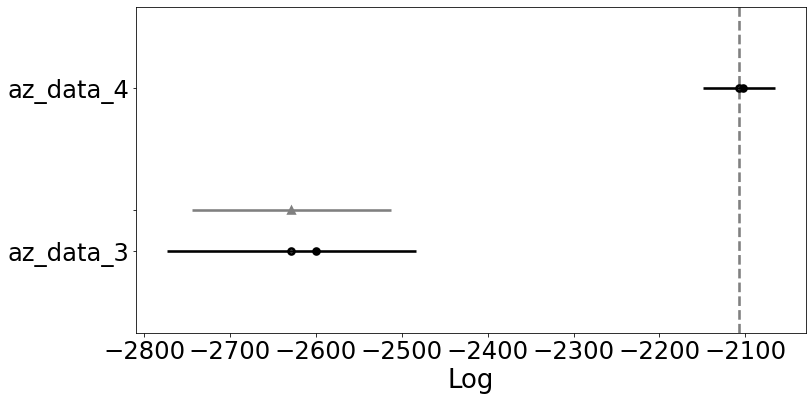

In [5]:
# loo comparison
loo_compare = az.compare({"az_data_3" : az_data_3, "az_data_4" : az_data_4}, ic="loo")
az.plot_compare(loo_compare, figsize=(12, 6))

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


<AxesSubplot:xlabel='Log'>

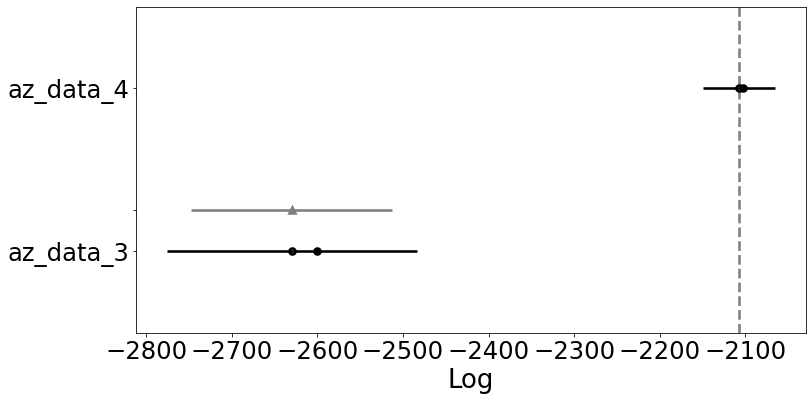

In [6]:
# waic comparison
loo_compare = az.compare({"az_data_3" : az_data_3, "az_data_4" : az_data_4}, ic="waic")
az.plot_compare(loo_compare, figsize=(12, 6))

### Excercise 3 - compare models with different numbers of predictors

1. Compile model
2. Compare models for 1, 2 and 3 predictors as in previous excercise

In [7]:
model_5 = CmdStanModel(stan_file='code_5.stan')
print("Len of df_2 =", len(df_2))

y = np.array(df_2[:N])
X_part = np.array(df_2[N:2*N])

pred_1 = model_5.sample(data={"N" : N,
                              "K" : 1,
                              "y" : y,
                              "X" : X_part.reshape(N, 1)
                              },
                        seed=29042020)
az_pred_1 = az.from_cmdstanpy(pred_1)
pred_2 = model_5.sample(data={"N" : N,
                              "K" : 2,
                              "y" : y,
                              "X" : np.concatenate((X_part, X_part)).reshape(N, 2)
                              },
                        seed=29042020)
az_pred_2 = az.from_cmdstanpy(pred_2)
pred_3 = model_5.sample(data={"N" : N,
                              "K" : 3,
                              "y" : y,
                              "X" : np.concatenate((X_part, X_part, X_part)).reshape(N, 3)
                              },
                        seed=29042020)
az_pred_3 = az.from_cmdstanpy(pred_3)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


Len of df_2 = 7002


chain 1 |          | 00:00 Status


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)



chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)




chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)




chain 1 |██████████| 00:01 Sampling completed                       
chain 2 |██████████| 00:01 Sampling completed                       
chain 3 |██████████| 00:01 Sampling completed                       
chain 4 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


<AxesSubplot:xlabel='Log'>

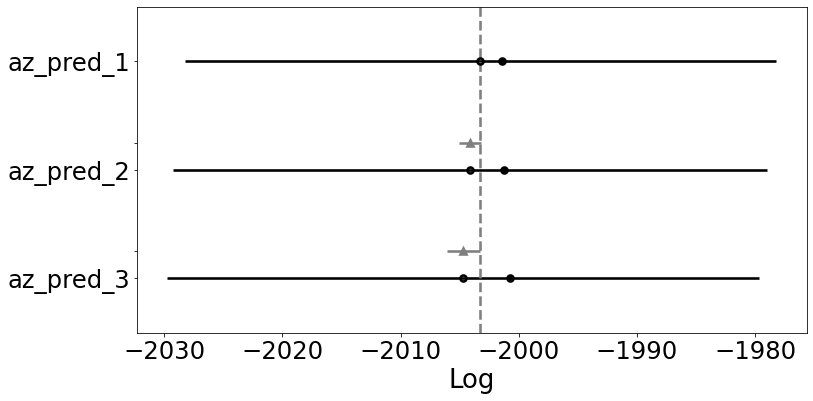

In [8]:
# loo comparison
loo_compare = az.compare({"az_pred_1" : az_pred_1, "az_pred_2" : az_pred_2, "az_pred_3" : az_pred_3}, ic="loo")
az.plot_compare(loo_compare, figsize=(12, 6))

<AxesSubplot:xlabel='Log'>

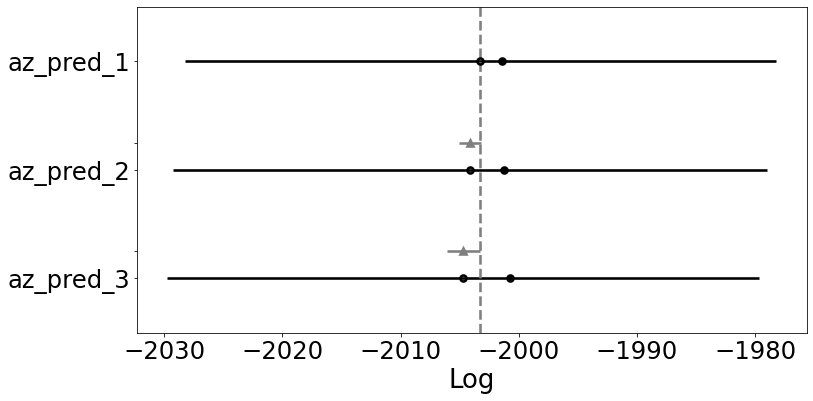

In [9]:
# waic comparison
loo_compare = az.compare({"az_pred_1" : az_pred_1, "az_pred_2" : az_pred_2, "az_pred_3" : az_pred_3}, ic="waic")
az.plot_compare(loo_compare, figsize=(12, 6))